In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from scipy.stats import spearmanr
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

try:
    df_train = pd.read_csv("train_multitask.csv")
    df_val = pd.read_csv("val_multitask.csv")
    df_test = pd.read_csv("test_multitask.csv")
    print(f"Train shape: {df_train.shape}")
    print(f"Val shape:   {df_val.shape}")
    print(f"Test shape:  {df_test.shape}")
except FileNotFoundError as e:
    exit()


genre_cols = [c for c in df_train.columns if c.startswith("genre_")]
pop_col = "popularity"
X_cols = [c for c in df_train.columns if c not in genre_cols + [pop_col]]


Train shape: (35000, 23)
Val shape:   (7500, 23)
Test shape:  (7500, 23)


In [2]:


def extract_data(df):


    X = df[X_cols].values.astype("float32")
    y_genre = df[genre_cols].values.astype("float32")

    y_pop = df[pop_col].values.astype("float32").reshape(-1, 1)
    return X, y_genre, y_pop


X_train, y_genre_train, y_pop_train = extract_data(df_train)
X_val, y_genre_val, y_pop_val = extract_data(df_val)
X_test, y_genre_test, y_pop_test = extract_data(df_test)


In [3]:


scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


y_pop_train_scaled = y_pop_train / 100.0
y_pop_val_scaled = y_pop_val / 100.0
y_pop_test_scaled = y_pop_test / 100.0


In [4]:

tf.random.set_seed(42)
np.random.seed(42)

input_dim = X_train.shape[1]
num_genres = y_genre_train.shape[1]

inp = layers.Input(shape=(input_dim,), name="input_features")

# ---  (Shared Layers) ---
x = layers.Dense(256, activation="relu")(inp)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# ---  Genre  ---
g = layers.Dense(64, activation="relu")(x)
g = layers.Dropout(0.2)(g)
out_genre = layers.Dense(num_genres, activation="softmax", name="genre")(g)

# --- Popularity ---
p = layers.Dense(64, activation="relu")(x)
p = layers.Dropout(0.2)(p)
out_pop = layers.Dense(1, activation="sigmoid", name="popularity")(p)

model = models.Model(inputs=inp, outputs=[out_genre, out_pop])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss={
        "genre": "categorical_crossentropy",
        "popularity": "mse",
    },
    loss_weights={
        "genre": 1.0,
        "popularity": 5.0
    },
    metrics={
        "genre": ["accuracy"],
        "popularity": ["mae"]
    },
)


In [5]:


es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=2,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1
)


history = model.fit(
    X_train,
    {"genre": y_genre_train, "popularity": y_pop_train_scaled},
    validation_data=(
        X_val,
        {"genre": y_genre_val, "popularity": y_pop_val_scaled},
    ),
    epochs=100,
    batch_size=128,
    callbacks=[es, lr_schedule],
    verbose=2,
)


Epoch 1/100
274/274 - 13s - 48ms/step - genre_accuracy: 0.2844 - genre_loss: 2.0538 - loss: 2.3450 - popularity_loss: 0.0580 - popularity_mae: 0.1909 - val_genre_accuracy: 0.3953 - val_genre_loss: 1.6922 - val_loss: 1.8013 - val_popularity_loss: 0.0218 - val_popularity_mae: 0.1192 - learning_rate: 3.0000e-04
Epoch 2/100
274/274 - 1s - 4ms/step - genre_accuracy: 0.3515 - genre_loss: 1.7594 - loss: 1.9223 - popularity_loss: 0.0325 - popularity_mae: 0.1437 - val_genre_accuracy: 0.4117 - val_genre_loss: 1.5476 - val_loss: 1.6507 - val_popularity_loss: 0.0205 - val_popularity_mae: 0.1151 - learning_rate: 3.0000e-04
Epoch 3/100
274/274 - 1s - 4ms/step - genre_accuracy: 0.3696 - genre_loss: 1.6866 - loss: 1.8183 - popularity_loss: 0.0263 - popularity_mae: 0.1288 - val_genre_accuracy: 0.4232 - val_genre_loss: 1.5252 - val_loss: 1.6170 - val_popularity_loss: 0.0183 - val_popularity_mae: 0.1079 - learning_rate: 3.0000e-04
Epoch 4/100
274/274 - 1s - 4ms/step - genre_accuracy: 0.3875 - genre_loss:

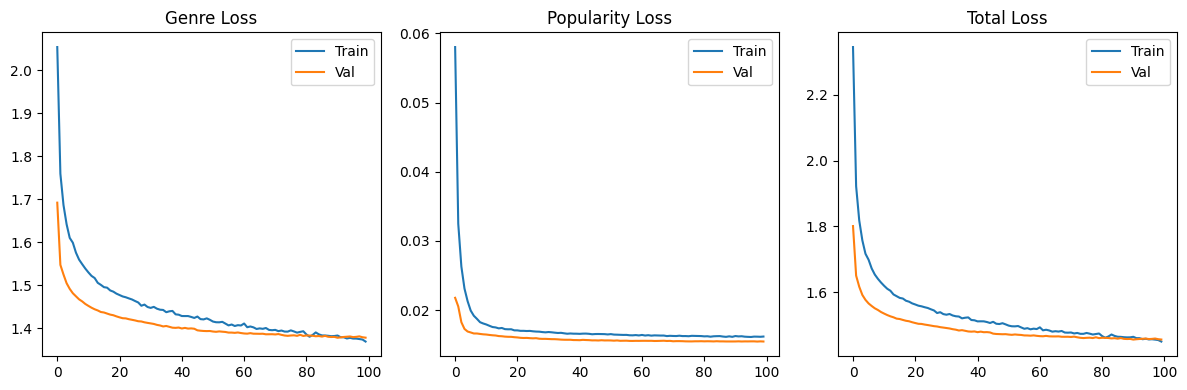

In [6]:



# plot
# ==========================================
def plot_history(history):
    loss = history.history
    plt.figure(figsize=(12, 4))

    # Genre Loss
    plt.subplot(1, 3, 1)
    plt.plot(loss['genre_loss'], label='Train')
    plt.plot(loss['val_genre_loss'], label='Val')
    plt.title('Genre Loss')
    plt.legend()

    # Popularity Loss
    plt.subplot(1, 3, 2)
    plt.plot(loss['popularity_loss'], label='Train')
    plt.plot(loss['val_popularity_loss'], label='Val')
    plt.title('Popularity Loss')
    plt.legend()

    # Total Loss
    plt.subplot(1, 3, 3)
    plt.plot(loss['loss'], label='Train')
    plt.plot(loss['val_loss'], label='Val')
    plt.title('Total Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


try:
    plot_history(history)
except:
    pass


genre_test_pred_proba, pop_test_pred_scaled = model.predict(X_test, verbose=0)

def eval_split(name, y_genre_true, y_pop_true, genre_pred_proba, pop_pred_scaled):
    print(f"=== {name} Results ===")

    # --- Genre  ---
    y_true_labels = np.argmax(y_genre_true, axis=1)
    y_pred_labels = np.argmax(genre_pred_proba, axis=1)

    acc = accuracy_score(y_true_labels, y_pred_labels)
    macro_f1 = f1_score(y_true_labels, y_pred_labels, average="macro")

    print(f"Genre Accuracy: {acc:.4f}")
    print(f"Genre Macro-F1: {macro_f1:.4f}")

    # --- Popularity  ---
    y_true_pop = y_pop_true.reshape(-1)

    y_pred_pop = pop_pred_scaled.reshape(-1) * 100.0

    rmse = np.sqrt(mean_squared_error(y_true_pop, y_pred_pop))
    mae = mean_absolute_error(y_true_pop, y_pred_pop)
    r2 = r2_score(y_true_pop, y_pred_pop)
    spearman, _ = spearmanr(y_true_pop, y_pred_pop)

    print(f"Pop RMSE:       {rmse:.4f}")
    print(f"Pop MAE:        {mae:.4f}")
    print(f"Pop R2:         {r2:.4f}")
    print(f"Pop Spearman:   {spearman:.4f}")
    print("-" * 30 + "\n")

In [7]:



eval_split(
    "TEST SET",
    y_genre_test,
    y_pop_test,
    genre_test_pred_proba,
    pop_test_pred_scaled,)

=== TEST SET Results ===
Genre Accuracy: 0.4775
Genre Macro-F1: 0.4603
Pop RMSE:       12.5442
Pop MAE:        9.8124
Pop R2:         0.3468
Pop Spearman:   0.5832
------------------------------



In [8]:
# ============================================================================

# ============================================================================
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))


    axes[0, 0].plot(history.history['loss'], label='Train')
    axes[0, 0].plot(history.history['val_loss'], label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True)


    axes[0, 1].plot(history.history['genre_accuracy'], label='Train')
    axes[0, 1].plot(history.history['val_genre_accuracy'], label='Val')
    axes[0, 1].set_title('Genre Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Popularity MAE
    axes[1, 0].plot(history.history['popularity_mae'], label='Train')
    axes[1, 0].plot(history.history['val_popularity_mae'], label='Val')
    axes[1, 0].set_title('Popularity MAE')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True)


    axes[1, 1].plot(history.history['learning_rate'])
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)


    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')



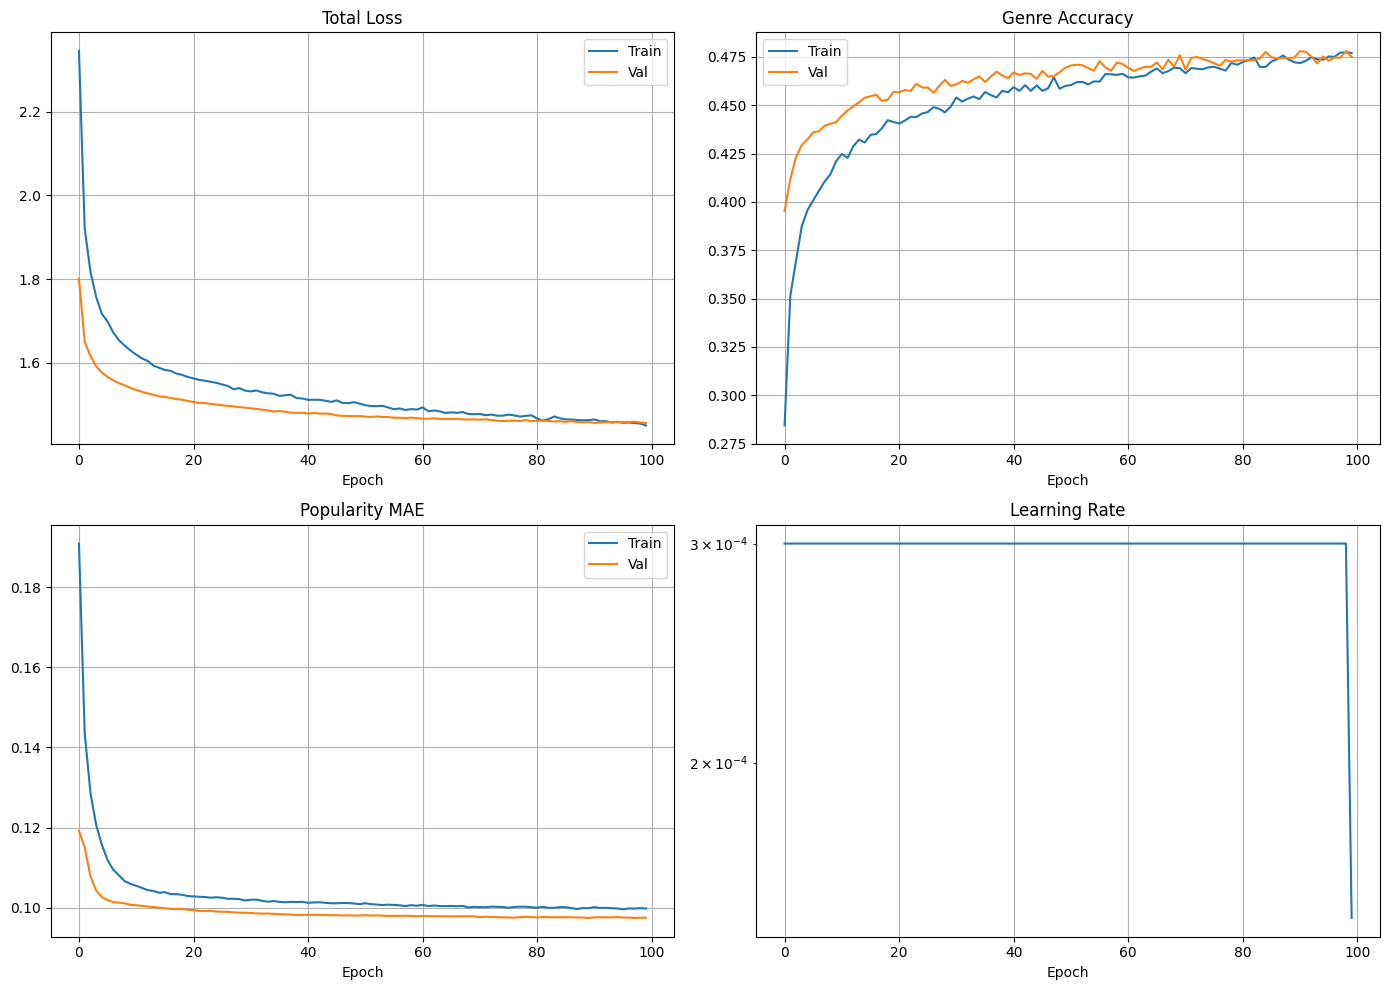

In [9]:
 plot_training_history(history)